## Forecasting Influenza-Like Illness in Kent County, Michigan

**Lillian Jensen**

---
**Research Question**

Does a county-specific time series model of ILI incidence with local syndromic data, Google search trends data, weather data, and air quality data have a statistically significant improvement on ILI prediction compared to historical trends alone?

**Datasets to be Used**

This analysis uses heterogeneous, multi-source data. Kent County ILI incidence data is from the Michigan Disease Surveillance System (MDSS), ED visits data is from the Michigan Syndromic Surveillance System (MSSS), historical air quality data is from a publicly available EPA database, search term trends come from Google’s Health Trends API, and climate data was sourced from the NOAA Climate Online Data Access.


---
*Setting up code environment*

In [364]:
import pandas as pd
import plotly.express as px
from datetime import datetime
from epiweeks import Week, Year
from calendar import month_name
from tabulate import tabulate
import matplotlib.pyplot as plt
from sklearn import preprocessing
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.stattools as smt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
from scipy.stats import chi2_contingency
import seaborn as sns
from scipy.stats import pearsonr
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings

warnings.filterwarnings('ignore')

## Some helpful functions ##

def plot_ccf_sm(target, exog, adjusted=False, nlags=52):
    """Plot CCF using Statsmodels"""
    ccfs = smt.ccf(target, exog, adjusted=False)[:nlags+1]
    lags = np.arange(len(ccfs))[:nlags+1]
    _ = plt.stem(lags, ccfs)
    _ = plt.title(f"Cross Correlations: {target.name} & {exog.name}")
    plt.show()
    plt.close()

def crosscorr(x: pd.Series, y: pd.Series, lag: int=0) -> float:
    """ Lag-N cross correlation. 
    Shifted data (y) filled with NaNs 
    """
    return x.corr(y.shift(lag),)

def difference(dataset, n):
    """ this function intakes a list of values, 
    subtracts the nth prior value,
    and returns the list of differenced values.
    """
    return pd.Series([dataset[i] - dataset[i - n] for i in range(1, len(dataset))])

def ADF(time_series, max_lags):
    """
    Format and print Ad-Fuller test output
    """
    t_stat, p_value, lags, _, critical_values, _ = adfuller(
                                                            time_series,
                                                            maxlag=max_lags
                                                            )
    print(f'ADF Statistic: {t_stat:.2f}')
    print(f'p-value: {p_value:.2f}')
    print(f'lags: {lags}')
    for key, value in critical_values.items():
        print('Critial Values:')
        print(f'   {key}, {value:.2f}')
        
def means_by_month_make_pretty(df_means: pd.DataFrame) -> pd.DataFrame:
        df = df_means.apply(lambda x: round(x,3))
        df = df.reset_index().rename(columns={'Month':'Variable'}).set_index('Variable')
        df = df.rename(columns=pretty_var_names)
        df = df.T
        return df

def get_month_case_weights(df: pd.DataFrame) -> pd.DataFrame:
    ind_cont_vars = [v for v in cont_vars if v != 'Cases']
    total_cases = df.groupby('Month')['Cases'].sum().sum()
    month_case_totals = pd.DataFrame(df.groupby('Month')['Cases'].sum())
    weights = month_case_totals / total_cases
    weighted_df = df[cont_vars+['Month']]
    weighted_df['weight'] = weighted_df['Month'].apply(lambda x: weights.loc[weights.index==x].values[0][0])
    weighted_transformed_df = pd.DataFrame()
    weighted_transformed_df['Cases'] = weighted_df['Cases'] / weighted_df["weight"]
    weighted_transformed_df[ind_cont_vars] = weighted_df[ind_cont_vars]
    return weighted_transformed_df


pretty_var_names = {
                    'cases'             :   'Cases',
                    'ed_visits'         :   'EDVisits',
                    'wind'              :   'Wind',
                    'precip'            :   'Precip (in)',
                    'snow'              :   'Snow (in)',
                    'temp'              :   'Temp (F)',
                    'aqi'               :   'AQI',
                    'flu_ggl_searches'  :   "Flu GS",
                    'cough_ggl_searches':   "Cough GS",
                    'cold_ggl_searches' :   "Cold GS",
                    'co'                :   'CO',
                    'ozone'             :   'Ozone',
                    'pm10'              :   'PM10',
                    'pm25'              :   'PM2.5',
                    'no2'               :   'NO2',
                    'year'              :   'Year',
                    'top'               :   'Main Poll'
                    }

cont_vars = [
            'Cases', 'EDVisits', 'Wind', 'Precip (in)', 
            'Snow (in)', 'Temp (F)', 'AQI', 'CO', 'Ozone',
            'PM10', 'PM2.5', 'NO2', "Flu GS", 
            "Cough GS", "Cold GS"
            ]

months_ordered = [
                'January', 'February', 'March', 
                'April', 'May', 'June', 'July', 
                'August', 'September', 'October', 
                'November', 'December'
                ]

cases_variables = ['Cases','EDVisits']
weather_variables = ['Wind','Precip (in)','Snow (in)','Temp (F)']
air_quality_variables = ['AQI', 'CO', 'Ozone', 'PM10', 'PM2.5','NO2']
google_variables = ["Flu GS","Cough GS","Cold GS"]

In [365]:
df = pd.read_csv('data.csv', index_col=0)
df = df.rename(columns=pretty_var_names)

---
Monthly means will be calculated for each continuous variable alongside violin plots to visualize variable spreads. 

In [366]:
df_cont_vars_and_month = df.set_index('weekstart')[cont_vars+['Month']]
df_monthly_means = df_cont_vars_and_month.groupby('Month').mean()

pretty_means = means_by_month_make_pretty(df_monthly_means)
pretty_means = pretty_means[months_ordered]
for var in [cases_variables,weather_variables,google_variables,air_quality_variables]:
    print(tabulate(pretty_means.T[var], headers=var))
    print('')


              Cases    EDVisits
---------  --------  ----------
January    1719.95      108.065
February   1842.25      125.768
March      1729.71      112.968
April       874.59       66.492
May         864.59       57
June        150.4        35.117
July          4.906      27.906
August       29.185      27.246
September   741.8        46.092
October    1412.2        77.848
November   1246.33       74.656
December   1016.7       112.078

             Wind    Precip (in)    Snow (in)    Temp (F)
---------  ------  -------------  -----------  ----------
January    10.226          0.098        0.766      25.435
February   10.357          0.099        0.657      25.351
March      10.194          0.08         0.112      36.36
April      10.77           0.165        0.077      48.267
May         8.852          0.124        0          60.391
June        8.15           0.149        0          69.192
July        7.453          0.111        0          73.501
August      7.077          0.133  

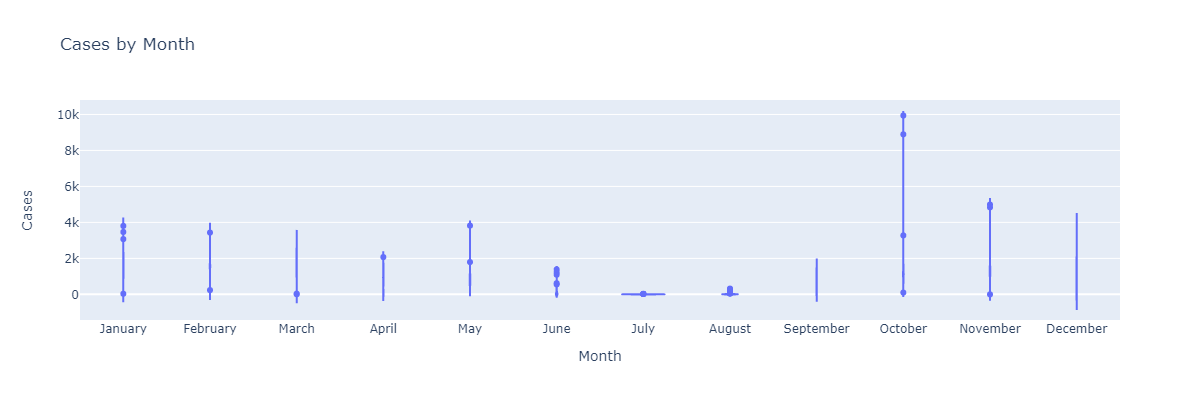

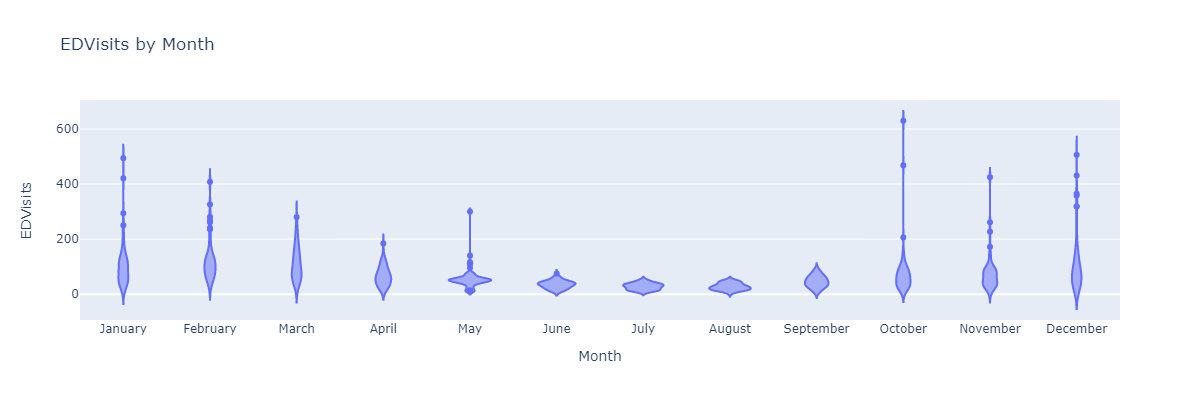

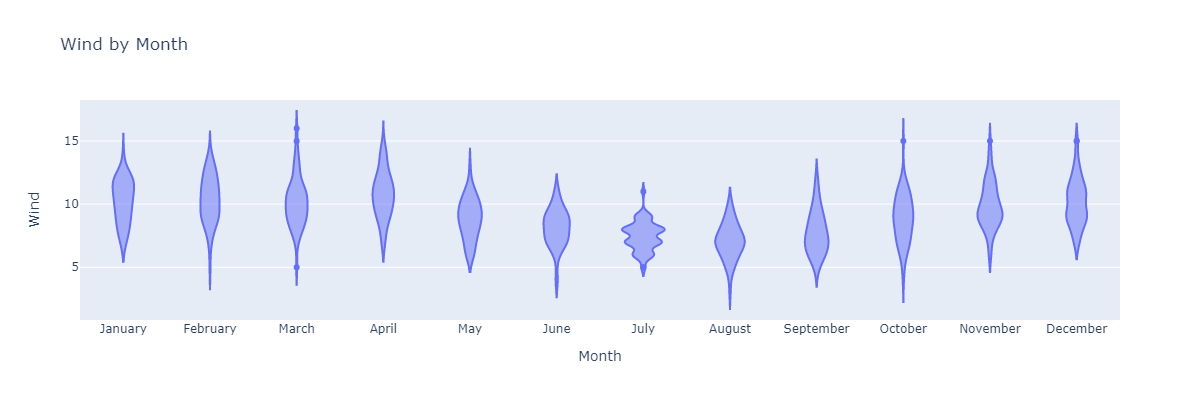

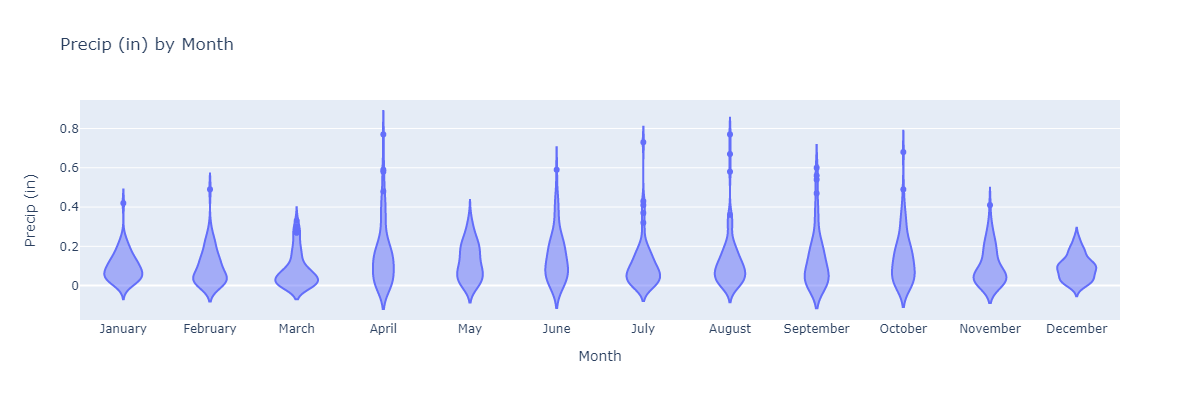

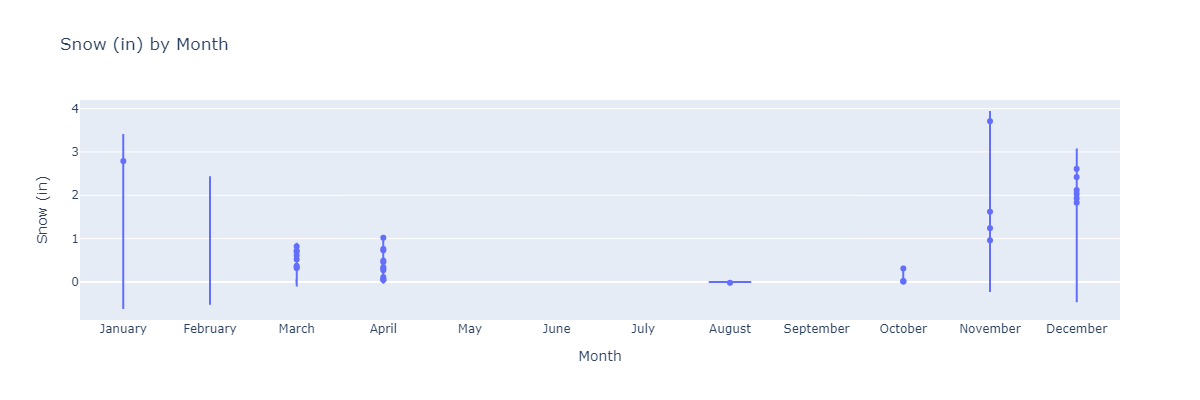

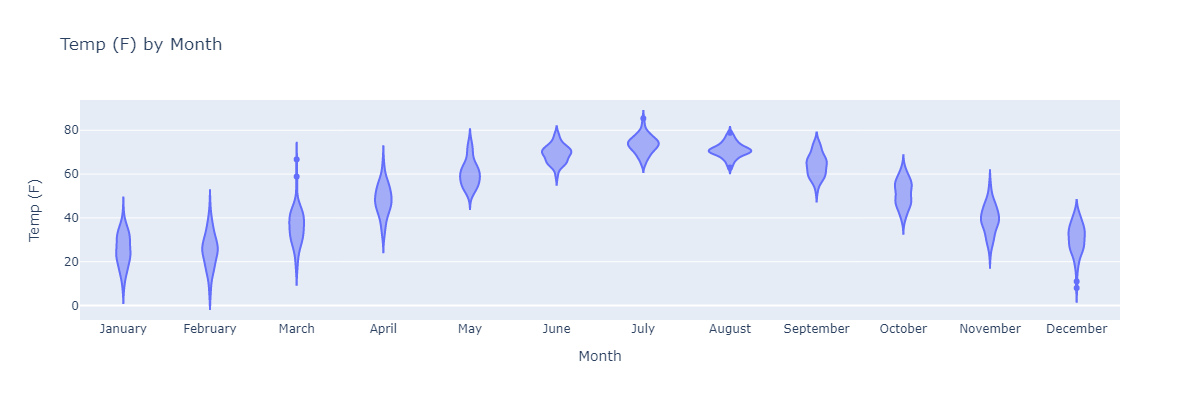

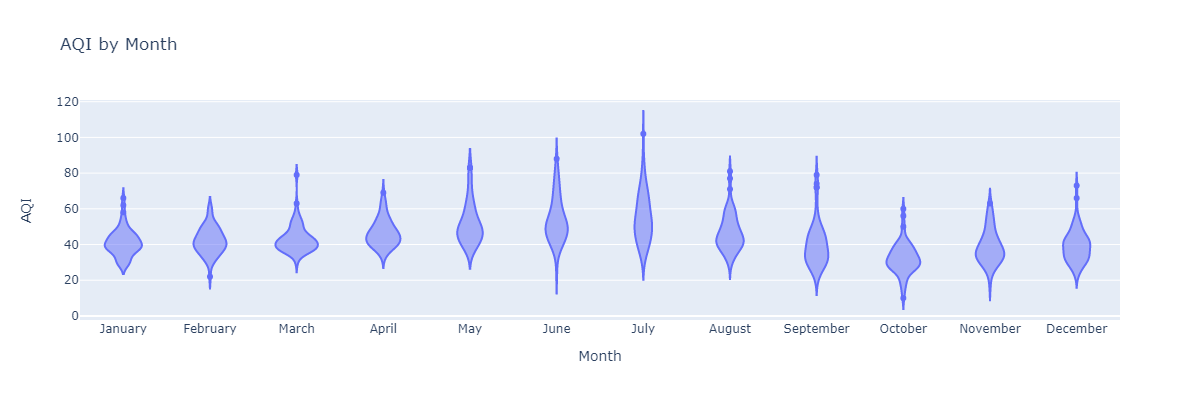

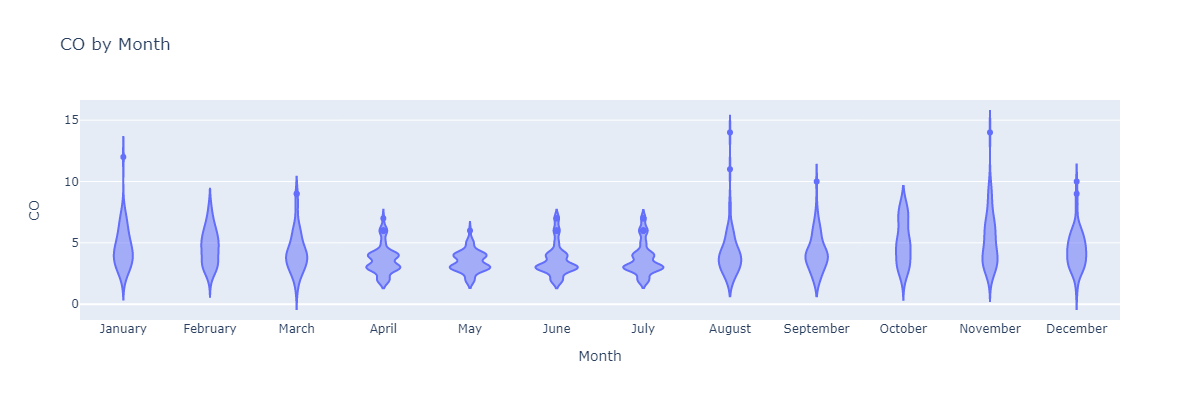

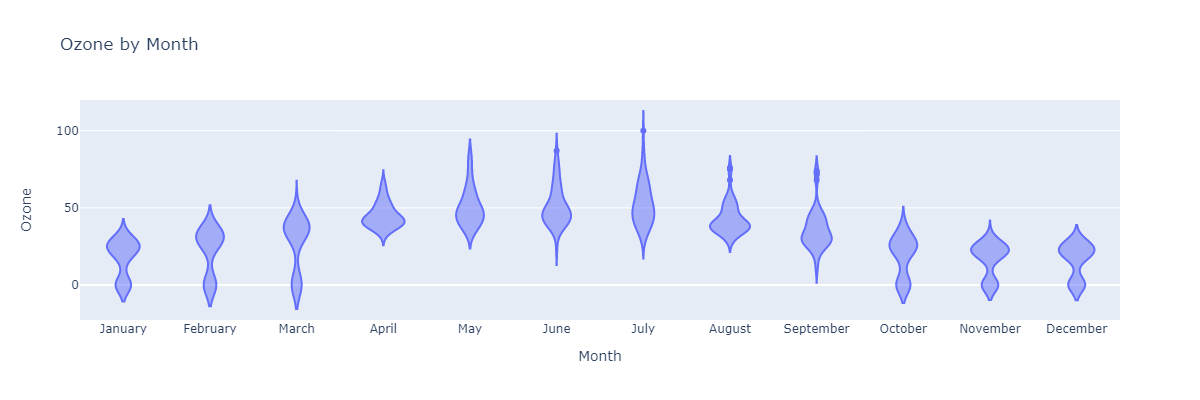

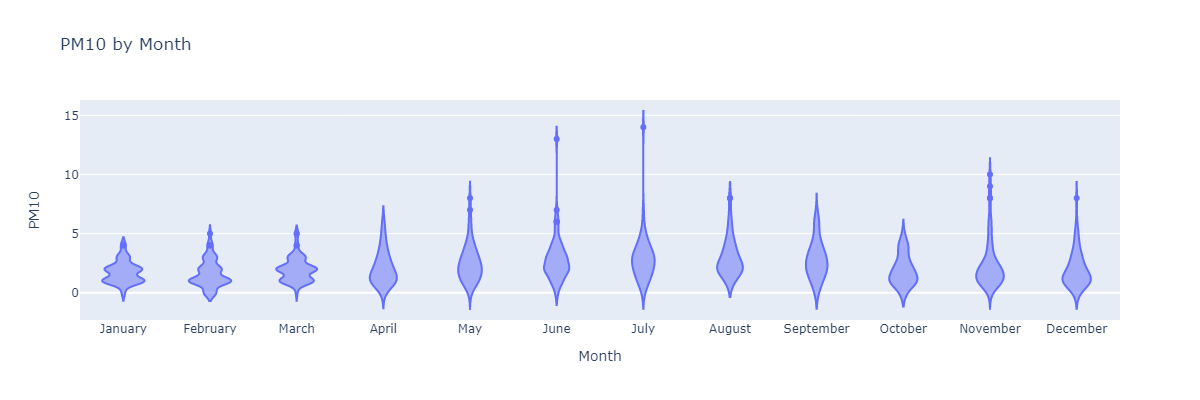

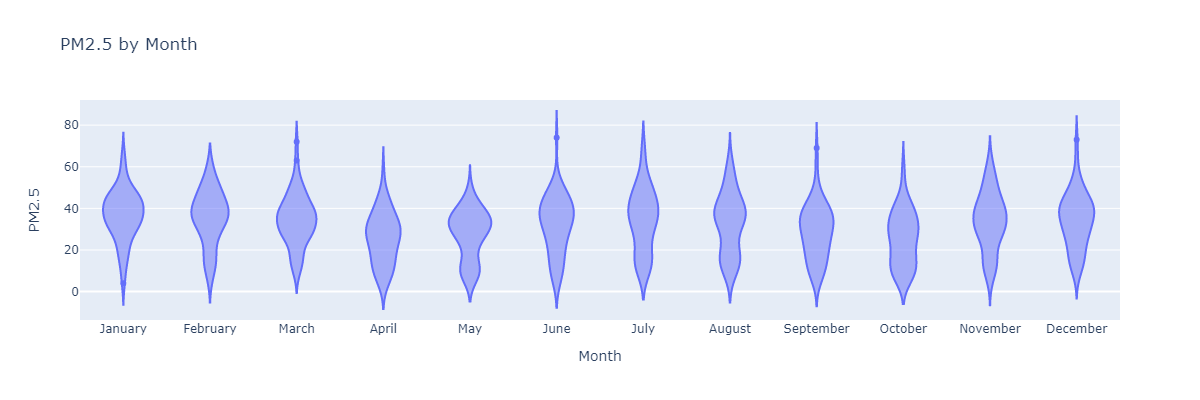

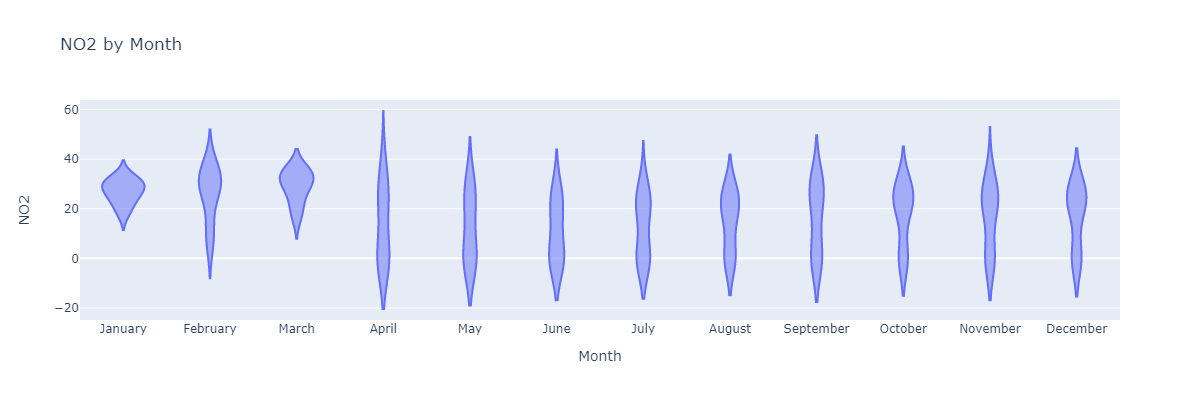

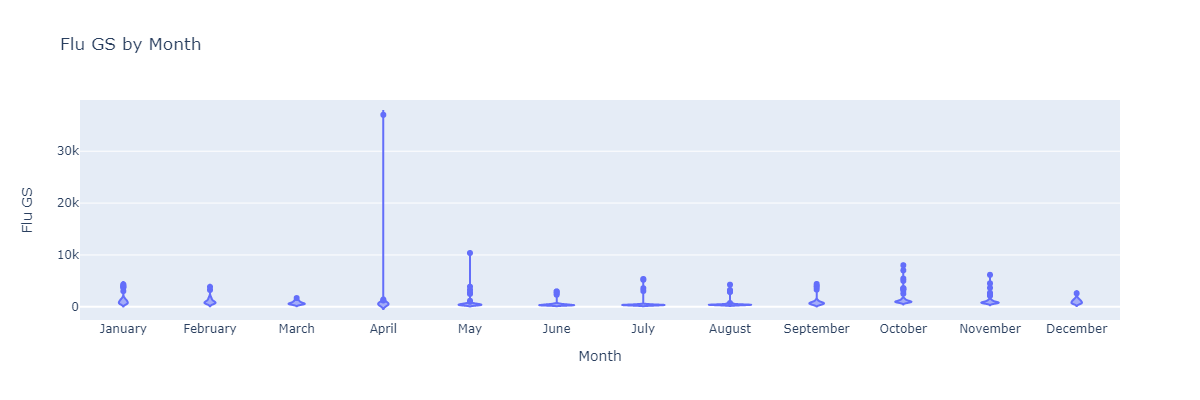

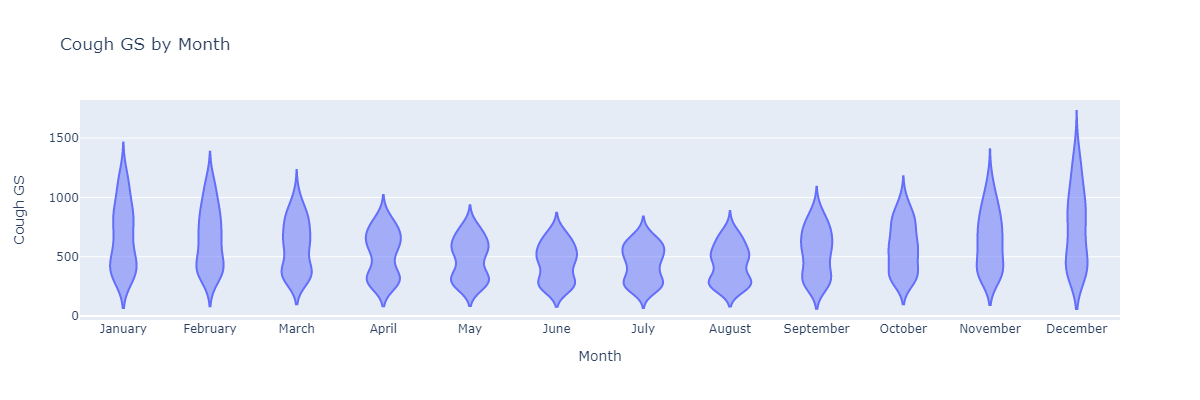

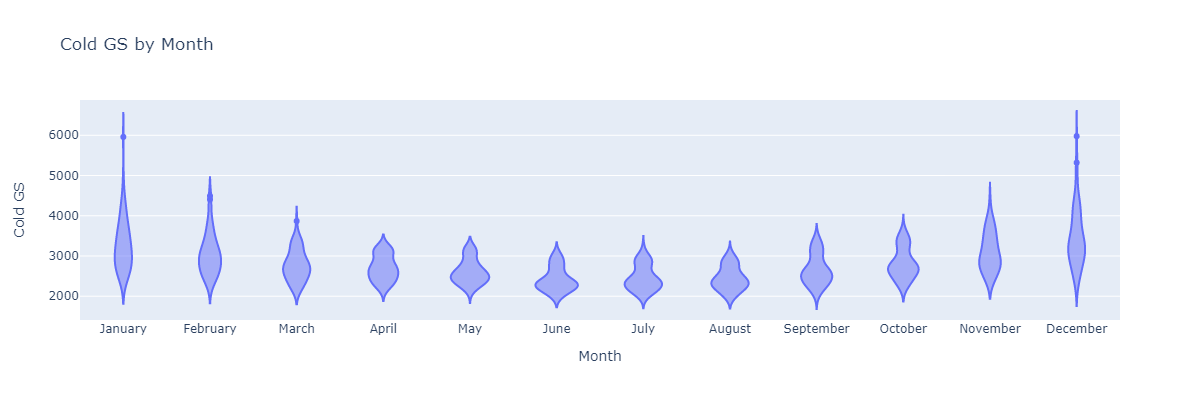

In [367]:
for var in cont_vars:
    fig = px.violin(df_cont_vars_and_month, x = 'Month', y = var, title=f'{var} by Month')
    fig.update_xaxes(categoryorder='array', categoryarray=months_ordered)
    fig.update_layout(autosize=False,width=1200,height=400)
    fig.show('png')

---
Associations between month and main pollutant will be explored with Chi2 test of association and visualized with a stacked bar chart. 


In [368]:
df_month_pollutant = df[['Month','Main Poll']]
df_month_dummy_pollutant = pd.get_dummies(df_month_pollutant.set_index('Main Poll')['Month']).reset_index()
month_pollutant_freq = df_month_dummy_pollutant.groupby('Main Poll').sum()[months_ordered]
print(tabulate(month_pollutant_freq.T, headers=month_pollutant_freq.T.columns))

             CO    NO2    Ozone    PM2.5
---------  ----  -----  -------  -------
January       0      4       11       47
February      1      3       18       34
March         0      4       32       26
April         0      0       57        4
May           0      0       61        0
June          0      0       56        4
July          0      0       56        8
August        0      0       49       16
September     1      0       44       20
October       4      5       22       35
November      0      4       16       44
December      0      5       16       43


In [369]:
stat, p, dof, expected = chi2_contingency(month_pollutant_freq)

print(f"Chisq         : {stat}")
print(f"p-value       : {p}")
print(f"Deg. Freedom  : {dof}")


Chisq         : 304.13808250339616
p-value       : 1.2884077202528089e-45
Deg. Freedom  : 33


In [370]:
melted_month_pollutant_freq = month_pollutant_freq.reset_index()
melted_month_pollutant_freq = melted_month_pollutant_freq.melt(
                                                                id_vars='Main Poll',
                                                                value_vars=months_ordered, 
                                                                var_name='Month',
                                                                value_name='freq'
                                                                )

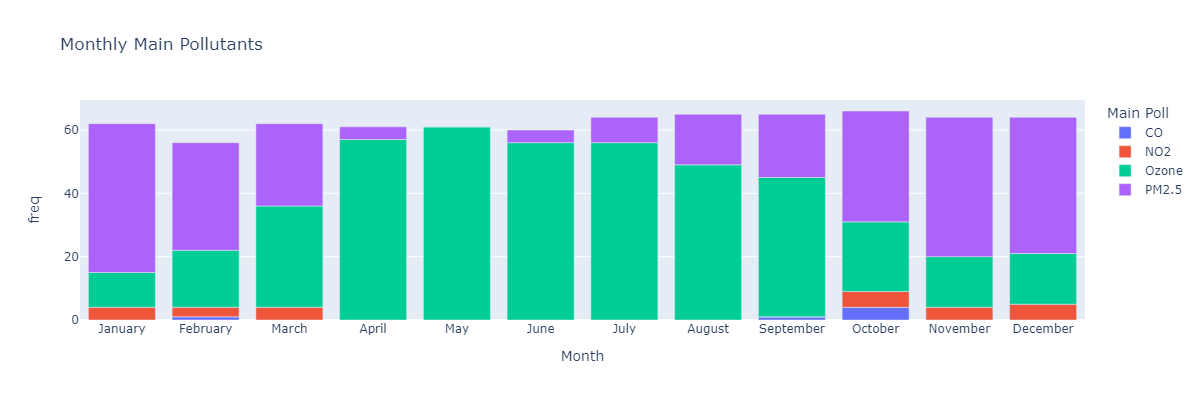

In [371]:
fig = px.bar(melted_month_pollutant_freq, x='Month',y='freq', color='Main Poll', title='Monthly Main Pollutants')
fig.update_layout(autosize=False,width=1200,height=400)
fig.show('png')

---
Continuous variables’ multicollinearity will be assessed with Pearson correlation and Variance Inflation Factors


In [372]:
scaler = preprocessing.StandardScaler()
scaled_df = df.set_index('weekstart')[cont_vars]
scaled_df = pd.DataFrame(scaler.fit_transform(scaled_df),columns=scaled_df.columns,index=scaled_df.index)
poll_dummies = pd.get_dummies(df.set_index('weekstart')['Main Poll'])
scaled_df[poll_dummies.columns] = poll_dummies[poll_dummies.columns]
scaled_df[[f'month_{m}' for m in range(1,13)]] = df.set_index('weekstart')[[f'month_{m}' for m in range(1,13)]]

In [373]:
pvals = scaled_df[cont_vars].corr(method=lambda x,y: pearsonr(x,y,)[1]) - np.eye(*corr_matrix.shape)
p = pvals.applymap(lambda x: ''.join(['*' for t in [.05,.01,.001] if x<=t]))
corr_matrix_sigs = corr_matrix[cont_vars].round(2).astype(str) + p
corr_matrix_sigs

,Cases,EDVisits,Wind,Precip (in),Snow (in),Temp (F),AQI,CO,Ozone,PM10,PM2.5,NO2,Flu GS,Cough GS,Cold GS
Cases,1.0***,0.2***,0.01***,0.06,-0.01***,-0.04***,-0.06***,-0.01,-0.04***,-0.01***,-0.04***,-0.13*,0.13***,0.01***,0.01***
EDVisits,0.2***,1.0***,0.24***,-0.01,0.17***,-0.43***,-0.26***,0.02,-0.16**,-0.21***,-0.01***,0.09*,0.33***,0.59***,0.45***
Wind,0.01***,0.24***,1.0***,0.2***,0.3***,-0.5***,-0.28***,-0.18,-0.31**,-0.23***,-0.1*,0.2**,0.07*,0.23***,0.3***
Precip (in),0.06,-0.01,0.2***,1.0***,0.03,0.13***,-0.17***,-0.12,-0.03,-0.17***,-0.14,0.03,0.12**,-0.01,-0.03
Snow (in),-0.01***,0.17***,0.3***,0.03,1.0***,-0.58***,-0.14***,0.0,-0.32***,-0.19***,0.11***,0.09,0.03,0.18***,0.41***
Temp (F),-0.04***,-0.43***,-0.5***,0.13***,-0.58***,1.0***,0.35***,-0.15,0.63***,0.28***,-0.08***,-0.29***,-0.12**,-0.37***,-0.56***
AQI,-0.06***,-0.26***,-0.28***,-0.17***,-0.14***,0.35***,1.0***,0.01***,0.6***,0.43***,0.48,-0.11**,-0.18***,-0.31***,-0.34***
CO,-0.01,0.02,-0.18,-0.12,0.0,-0.15,0.01***,1.0***,-0.3**,0.18,0.07,0.6,0.03,-0.08*,-0.01*
Ozone,-0.04***,-0.16**,-0.31**,-0.03,-0.32***,0.63***,0.6***,-0.3**,1.0***,0.21,-0.05***,-0.3***,-0.13,-0.08***,-0.29***
PM10,-0.01***,-0.21***,-0.23***,-0.17***,-0.19***,0.28***,0.43***,0.18,0.21,1.0***,0.25,-0.22,-0.12***,-0.22***,-0.25***


In [374]:
corr_matrix = scaled_df[cont_vars].corr()
corr_matrix.style.background_gradient(cmap='RdBu_r').format(precision=2)

,Cases,EDVisits,Wind,Precip (in),Snow (in),Temp (F),AQI,CO,Ozone,PM10,PM2.5,NO2,Flu GS,Cough GS,Cold GS
Cases,1.00,0.58,0.29,-0.04,0.22,-0.57,-0.29,0.01,-0.28,-0.18,0.24,0.09,0.27,0.17,0.23
EDVisits,0.58,1.00,0.24,-0.01,0.17,-0.43,-0.26,-0.04,-0.11,-0.21,0.15,-0.09,0.33,0.59,0.45
Wind,0.29,0.24,1.00,0.20,0.30,-0.50,-0.28,0.02,-0.12,-0.23,0.08,0.10,0.07,0.23,0.30
Precip (in),-0.04,-0.01,0.20,1.00,0.03,0.13,-0.17,-0.03,0.07,-0.17,-0.06,-0.02,0.12,-0.01,-0.03
Snow (in),0.22,0.17,0.30,0.03,1.00,-0.58,-0.14,-0.02,-0.29,-0.19,0.28,0.05,0.03,0.18,0.41
Temp (F),-0.57,-0.43,-0.50,0.13,-0.58,1.00,0.35,-0.01,0.47,0.28,-0.43,-0.14,-0.12,-0.37,-0.56
AQI,-0.29,-0.26,-0.28,-0.17,-0.14,0.35,1.00,-0.19,0.14,0.43,-0.06,-0.12,-0.18,-0.31,-0.34
CO,0.01,-0.04,0.02,-0.03,-0.02,-0.01,-0.19,1.00,-0.11,-0.00,-0.07,-0.02,-0.00,-0.08,-0.07
Ozone,-0.28,-0.11,-0.12,0.07,-0.29,0.47,0.14,-0.11,1.00,0.02,-0.92,-0.22,-0.01,-0.14,-0.24
PM10,-0.18,-0.21,-0.23,-0.17,-0.19,0.28,0.43,-0.00,0.02,1.00,-0.04,0.07,-0.12,-0.22,-0.25


In [375]:
weighted_transformed_df = get_month_case_weights(df)

corr_matrix = weighted_transformed_df[cont_vars].corr()
corr_matrix.style.background_gradient(cmap='RdBu_r').format(precision=2)

,Cases,EDVisits,Wind,Precip (in),Snow (in),Temp (F),AQI,CO,Ozone,PM10,PM2.5,NO2,Flu GS,Cough GS,Cold GS
Cases,1.00,0.20,0.01,0.06,-0.01,-0.04,-0.06,-0.01,-0.04,-0.01,-0.04,-0.13,0.13,0.01,0.01
EDVisits,0.20,1.00,0.24,-0.01,0.17,-0.43,-0.26,0.02,-0.16,-0.21,-0.01,0.09,0.33,0.59,0.45
Wind,0.01,0.24,1.00,0.20,0.30,-0.50,-0.28,-0.18,-0.31,-0.23,-0.10,0.20,0.07,0.23,0.30
Precip (in),0.06,-0.01,0.20,1.00,0.03,0.13,-0.17,-0.12,-0.03,-0.17,-0.14,0.03,0.12,-0.01,-0.03
Snow (in),-0.01,0.17,0.30,0.03,1.00,-0.58,-0.14,0.00,-0.32,-0.19,0.11,0.09,0.03,0.18,0.41
Temp (F),-0.04,-0.43,-0.50,0.13,-0.58,1.00,0.35,-0.15,0.63,0.28,-0.08,-0.29,-0.12,-0.37,-0.56
AQI,-0.06,-0.26,-0.28,-0.17,-0.14,0.35,1.00,0.01,0.60,0.43,0.48,-0.11,-0.18,-0.31,-0.34
CO,-0.01,0.02,-0.18,-0.12,0.00,-0.15,0.01,1.00,-0.30,0.18,0.07,0.60,0.03,-0.08,-0.01
Ozone,-0.04,-0.16,-0.31,-0.03,-0.32,0.63,0.60,-0.30,1.00,0.21,-0.05,-0.30,-0.13,-0.08,-0.29
PM10,-0.01,-0.21,-0.23,-0.17,-0.19,0.28,0.43,0.18,0.21,1.00,0.25,-0.22,-0.12,-0.22,-0.25


In [376]:
vif = pd.DataFrame()
vif['variable'] = scaled_df[cont_vars].columns
vif['VIF'] = [variance_inflation_factor(scaled_df[cont_vars].values,i) for i in range(len(cont_vars))]
vif

,variable,VIF
0,Cases,2.299165
1,EDVisits,2.873110
2,Wind,1.543296
3,Precip (in),1.252010
4,Snow (in),1.715992
5,Temp (F),3.888753
6,AQI,1.618102
7,CO,1.081416
8,Ozone,1.153301
9,PM10,1.340046


In [378]:
vif = pd.DataFrame()
vif['variable'] = weighted_transformed_df.dropna()[cont_vars].columns
vif['VIF'] = [variance_inflation_factor(weighted_transformed_df.dropna()[cont_vars].values,i) for i in range(len(cont_vars))]
vif

,variable,VIF
0,Cases,3.962663
1,EDVisits,7.899715
2,Wind,43.621879
3,Precip (in),2.449563
4,Snow (in),2.289847
5,Temp (F),33.186088
6,AQI,59.367211
7,CO,21.757052
8,Ozone,26.012255
9,PM10,6.753583


---
ILI cases will be modeled with months alone and with months + other variables to explore the impact of the other variables on cases.


In [379]:
x = sm.add_constant(scaled_df[[f'month_{m}' for m in range(1,13) if m != 6]])
y = scaled_df['Cases']
mod = sm.OLS(endog=y, exog=x, hasconst=True).fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Cases   R-squared:                       0.459
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     56.85
Date:                Mon, 04 Dec 2023   Prob (F-statistic):           9.40e-91
Time:                        16:50:47   Log-Likelihood:                -834.05
No. Observations:                 750   AIC:                             1692.
Df Residuals:                     738   BIC:                             1748.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8779      0.096     -9.168      0.000      -1.066      -0.690
month_1        1.7001      0.134     12.658      0.000       1.436       1.964
month_2        1.8326      0.138     13.298      0.000       1.562       2.103
month_3        1.7107      0.134     12.736      0.000       1.447       1.974
month_4        0.7844      0.135      5.817      0.000       0.520       1.049
month_5        0.7736      0.135      5.736      0.000       0.509       1.038
month_7       -0.1576      0.133     -1.182      0.237      -0.419       0.104
month_8       -0.1313      0.133     -0.989      0.323      -0.392       0.129
month_9        0.6406      0.133      4.824      0.000       0.380       0.901
month_10       1.3668      0.132     10.331      0.000       1.107       1.627
month_11       1.1871      0.133      8.907      0.000       0.925       1.449
month_12       0.9384      0.133      7.041      0.000       0.677       1.200
==============================================================================
Omnibus:                      835.680   Durbin-Watson:                   0.946
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            95336.797
Skew:                           5.124   Prob(JB):                         0.00
Kurtosis:                      57.275   Cond. No.                         13.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [380]:
## keep this one ##

x = sm.add_constant(scaled_df.drop(columns=['Cases','Ozone','month_6']))
y = scaled_df['Cases']
mod = sm.OLS(endog=y, exog=x, hasconst=True).fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Cases   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     53.32
Date:                Mon, 04 Dec 2023   Prob (F-statistic):          2.39e-142
Time:                        16:50:53   Log-Likelihood:                -682.82
No. Observations:                 750   AIC:                             1416.
Df Residuals:                     725   BIC:                             1531.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.5800      0.107     -5.398      0.000      -0.791      -0.369
EDVisits        0.5383      0.034     15.960      0.000       0.472       0.605
Wind           -0.0339      0.030     -1.138      0.255      -0.092       0.025
Precip (in)     0.0203      0.025      0.802      0.423      -0.029       0.070
Snow (in)      -0.0394      0.031     -1.263      0.207      -0.101       0.022
Temp (F)       -0.1283      0.073     -1.756      0.080      -0.272       0.015
AQI            -0.0649      0.033     -1.972      0.049      -0.130      -0.000
CO             -0.3389      0.265     -1.277      0.202      -0.860       0.182
PM10            0.0317      0.026      1.198      0.231      -0.020       0.084
PM2.5           0.0636      0.060      1.052      0.293      -0.055       0.182
NO2             0.0254      0.141      0.180      0.857      -0.252       0.303
Flu GS          0.0300      0.025      1.188      0.235      -0.020       0.080
Cough GS       -0.3823      0.052     -7.389      0.000      -0.484      -0.281
Cold GS         0.0704      0.054      1.309      0.191      -0.035       0.176
month_1         1.0728      0.200      5.366      0.000       0.680       1.465
month_2         1.1016      0.203      5.434      0.000       0.704       1.500
month_3         1.0467      0.173      6.044      0.000       0.707       1.387
month_4         0.4883      0.141      3.472      0.001       0.212       0.764
month_5         0.5762      0.117      4.910      0.000       0.346       0.807
month_7        -0.0929      0.112     -0.828      0.408      -0.313       0.127
month_8        -0.1467      0.114     -1.285      0.199      -0.371       0.077
month_9         0.5374      0.118      4.559      0.000       0.306       0.769
month_10        0.9529      0.141      6.774      0.000       0.677       1.229
month_11        0.8282      0.163      5.084      0.000       0.508       1.148
month_12        0.3932      0.188      2.094      0.037       0.025       0.762
==============================================================================
Omnibus:                      267.563   Durbin-Watson:                   1.377
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5810.097
Skew:                           1.066   Prob(JB):                         0.00
Kurtosis:                      16.468   Cond. No.                         37.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

---
The stationarity of ILI cases will be tested using the Adfuller Test of Stationarity. If the series fails to show stationarity, another Adfuller test will be performed on the first-differenced data.


In [381]:
cases_series = scaled_df[['Cases']]

In [382]:
ADF(cases_series, 52)

ADF Statistic: -2.29
p-value: 0.17
lags: 51
Critial Values:
   1%, -3.44
Critial Values:
   5%, -2.87
Critial Values:
   10%, -2.57


In [383]:
ADF(difference(cases_series['Cases'],1),52)

ADF Statistic: -11.78
p-value: 0.00
lags: 50
Critial Values:
   1%, -3.44
Critial Values:
   5%, -2.87
Critial Values:
   10%, -2.57


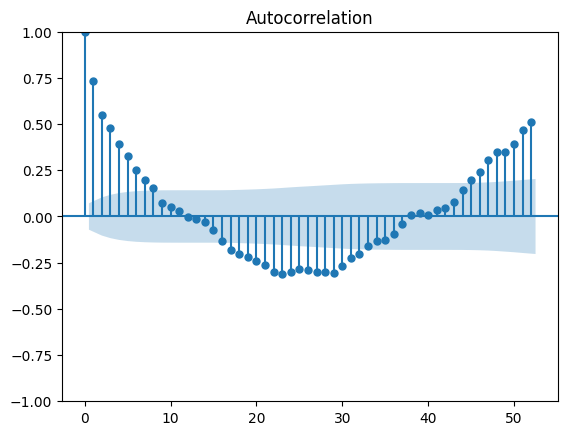

In [384]:
plot = plot_acf(cases_series, lags = 52)

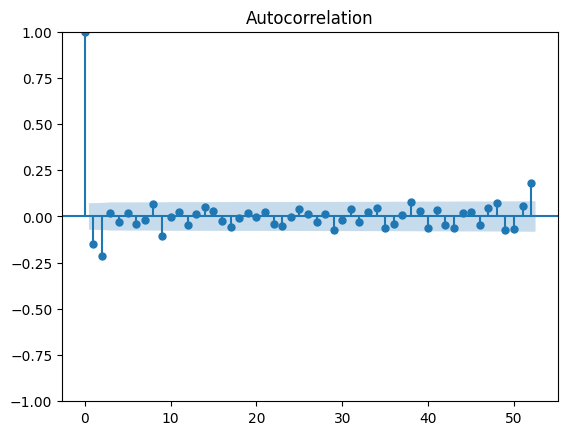

In [385]:
plot = plot_acf(difference(cases_series['Cases'],1), lags = 52)

---
If the cases series or its first-differenced transformation are indeed stationary, an autoregression model will be developed to explore any lagged-effects of past weeks in the data.


In [386]:
cases_series.index = pd.to_datetime(cases_series.index)
cases_series = cases_series.resample('W').first()
cases_series['Cases'] = cases_series['Cases'].fillna(method='ffill')

cases_series_preds = cases_series.copy()

In [387]:
mod = AutoReg(cases_series, 52)
res = mod.fit()
print(res.summary())

cases_series_preds['autoreg pred'] = res.predict()

cases_series_preds['autoreg accuracy (%)'] = (cases_series_preds['autoreg pred'] / cases_series_preds['Cases']) * 100


                            AutoReg Model Results                             
Dep. Variable:                  Cases   No. Observations:                  752
Model:                    AutoReg(52)   Log Likelihood                -653.568
Method:               Conditional MLE   S.D. of innovations              0.616
Date:                Mon, 04 Dec 2023   AIC                           1415.135
Time:                        16:51:17   BIC                           1660.894
Sample:                    07-30-2006   HQIC                          1510.136
                         - 12-22-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0055      0.023      0.235      0.814      -0.040       0.051
Cases.L1       0.6468      0.037     17.334      0.000       0.574       0.720
Cases.L2      -0.1449      0.045     -3.247      0.0

In [388]:
mod = AutoReg(cases_series, seasonal=True, lags=52)
res = mod.fit()
print(res.summary())

cases_series_preds['seasonal autoreg pred'] = res.predict()

cases_series_preds['seasonal autoreg accuracy (%)'] = (cases_series_preds['seasonal autoreg pred'] / cases_series_preds['Cases']) * 100


                            AutoReg Model Results                             
Dep. Variable:                  Cases   No. Observations:                  752
Model:              Seas. AutoReg(52)   Log Likelihood                -592.012
Method:               Conditional MLE   S.D. of innovations              0.564
Date:                Mon, 04 Dec 2023   AIC                           1394.025
Time:                        16:51:22   BIC                           1871.888
Sample:                    07-30-2006   HQIC                          1578.747
                         - 12-22-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4760      0.191     -2.494      0.013      -0.850      -0.102
s(2,52)       -0.0690      0.225     -0.306      0.759      -0.511       0.373
s(3,52)       -0.0586      0.239     -0.245      0.8

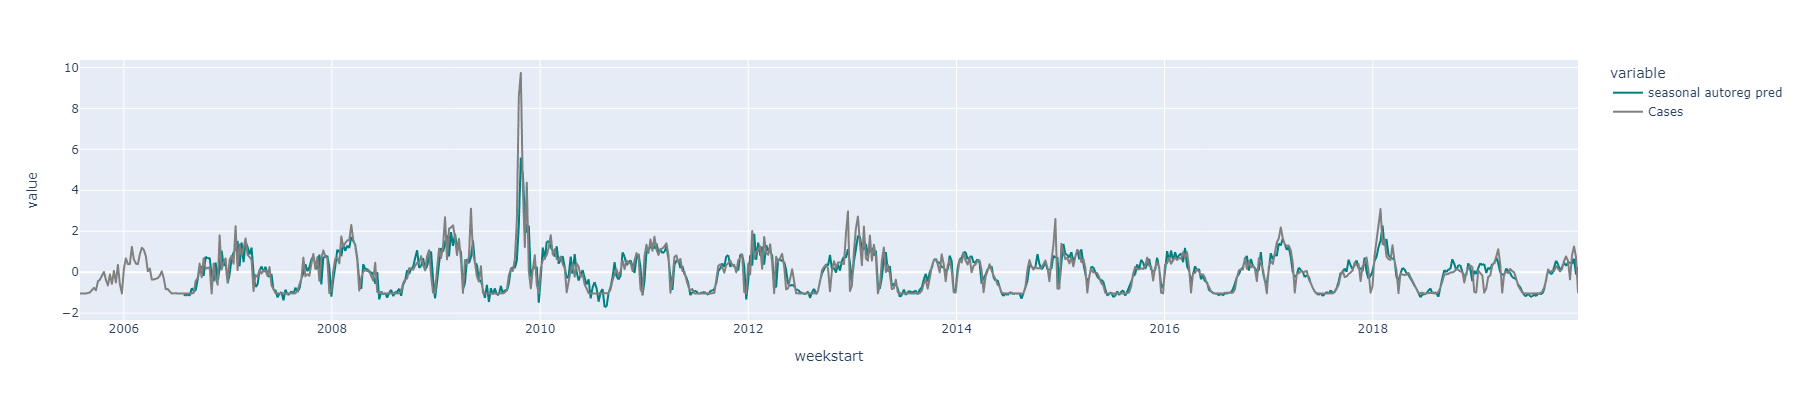

Median predictive accuracy: 92%


In [389]:
fig = px.line(cases_series_preds[['seasonal autoreg pred','Cases']], color_discrete_map={'Cases':'grey','seasonal autoreg pred':'teal'})
fig.update_layout(autosize=False,width=1800,height=400)
fig.show('png')

print(75*'=')
print('Median predictive accuracy: ' + str(round(cases_series_preds['seasonal autoreg accuracy (%)'].median())) + '%')
print(75*'=')

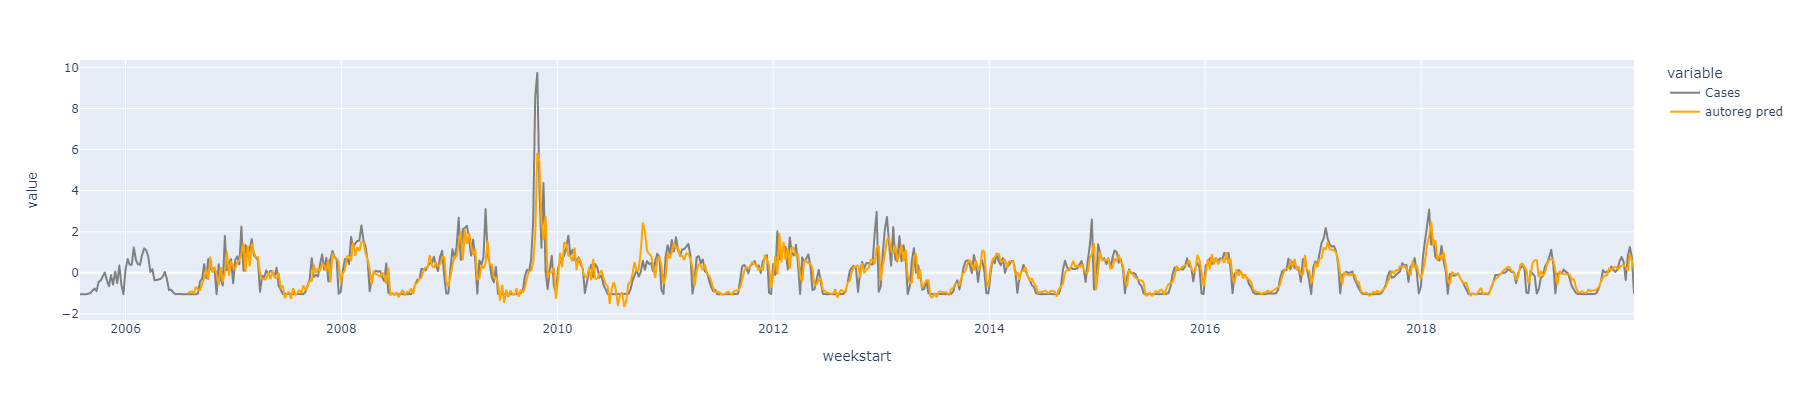

Median predictive accuracy: 82%


In [390]:
fig=px.line(cases_series_preds[['Cases','autoreg pred']], color_discrete_map={'autoreg pred':'orange','Cases':'grey'})
fig.update_layout(autosize=False,width=1800,height=400)
fig.show('png')

print(75*'=')
print('Median predictive accuracy: ' + str(round(cases_series_preds['autoreg accuracy (%)'].median())) + '%')
print(75*'=')

---
Delayed-effects of independent variables on ILI cases will be explored with cross-correlation plots to select lagged terms which may have an influence on cases. 


In [391]:
ind_cont_vars = [v for v in cont_vars if v != 'Cases']

Unadjusted


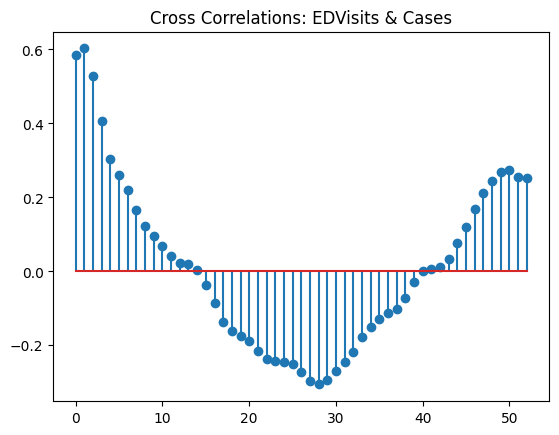

Adjusted for Month


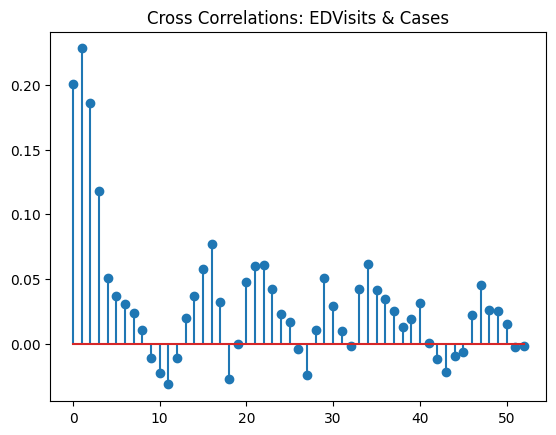

Unadjusted


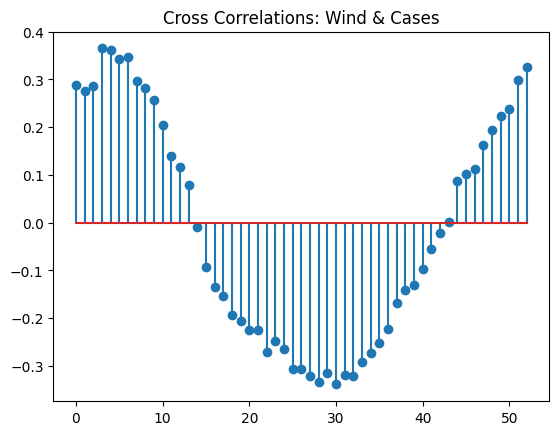

Adjusted for Month


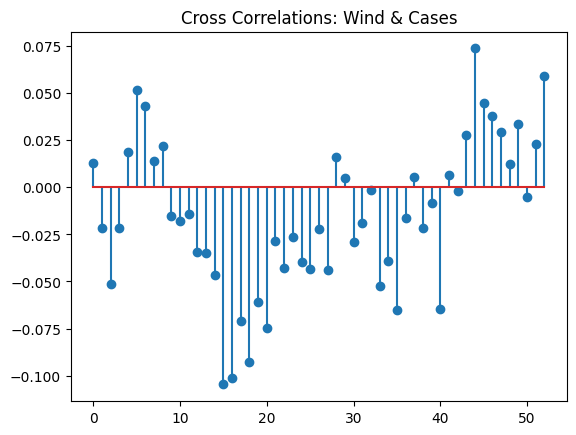

Unadjusted


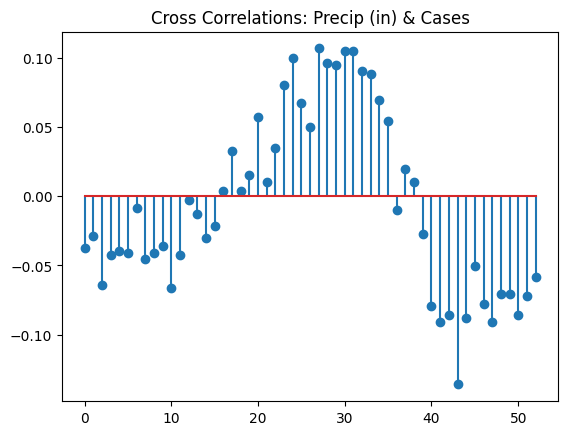

Adjusted for Month


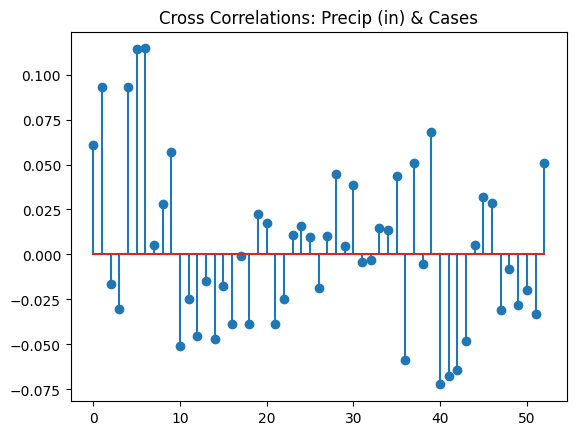

Unadjusted


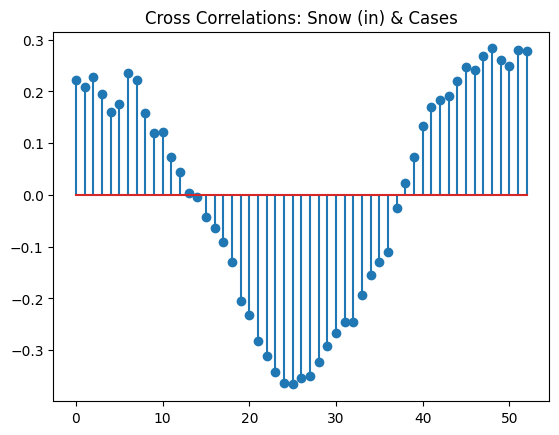

Adjusted for Month


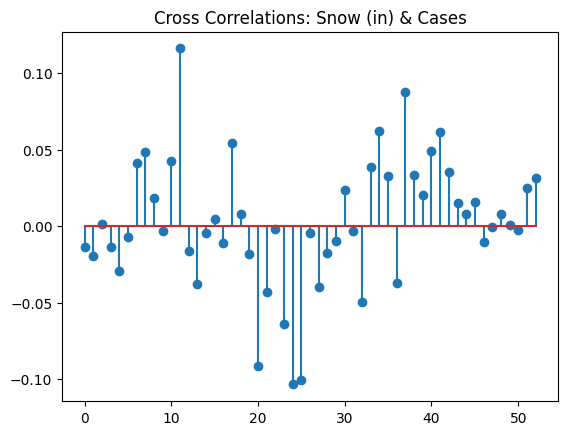

Unadjusted


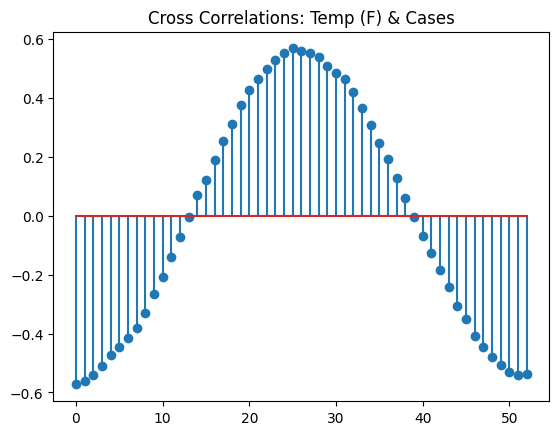

Adjusted for Month


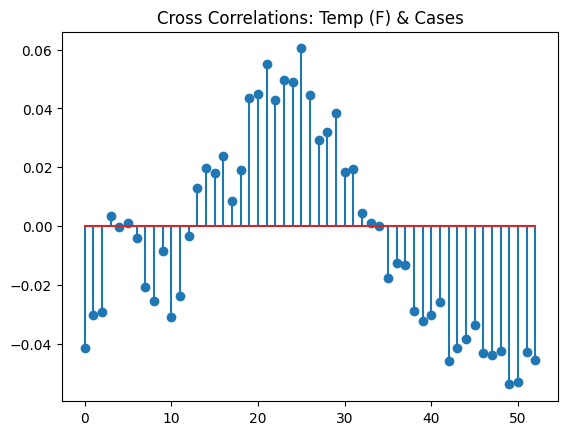

Unadjusted


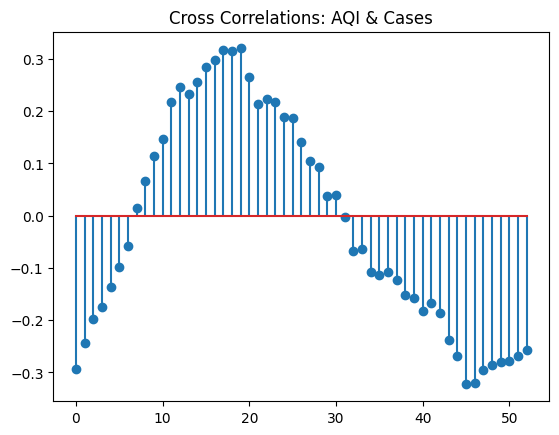

Adjusted for Month


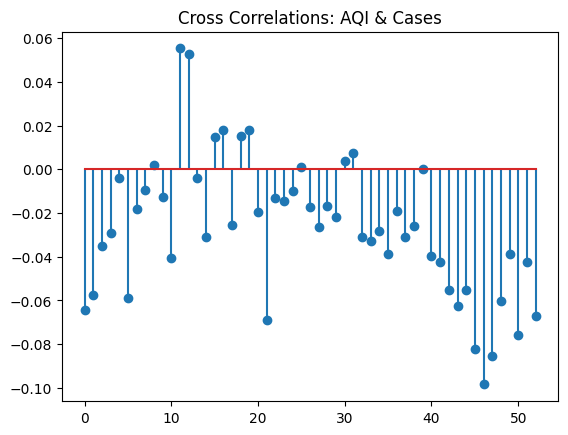

Unadjusted


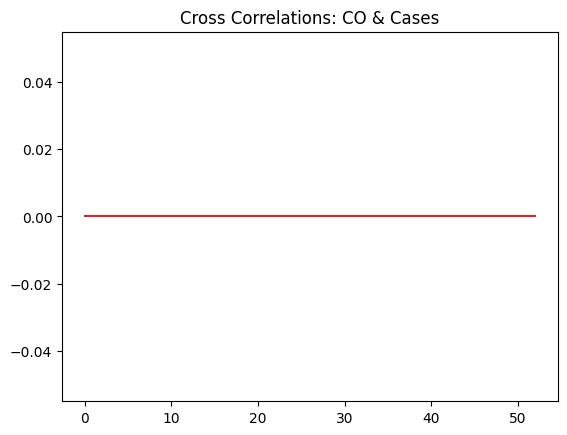

Adjusted for Month


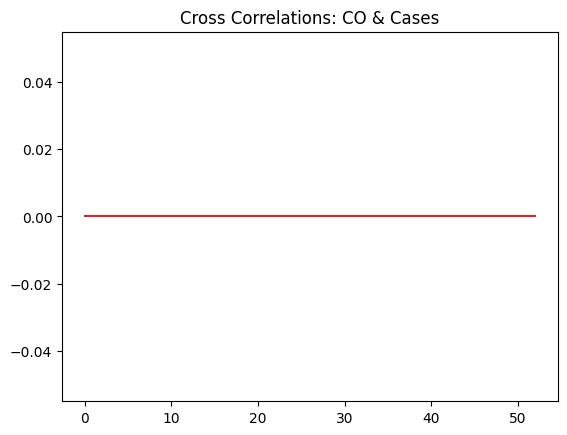

Unadjusted


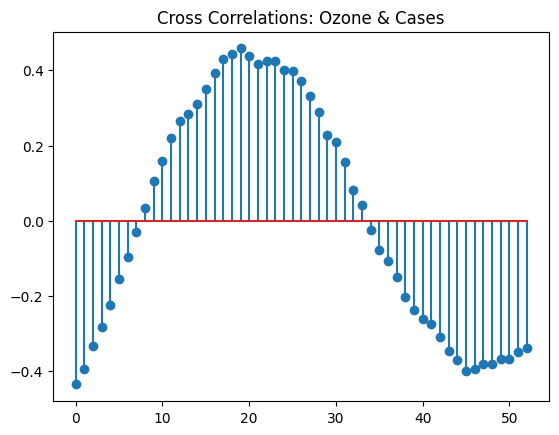

Adjusted for Month


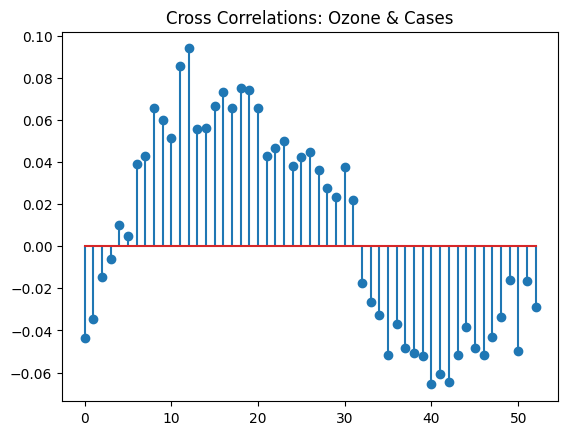

Unadjusted


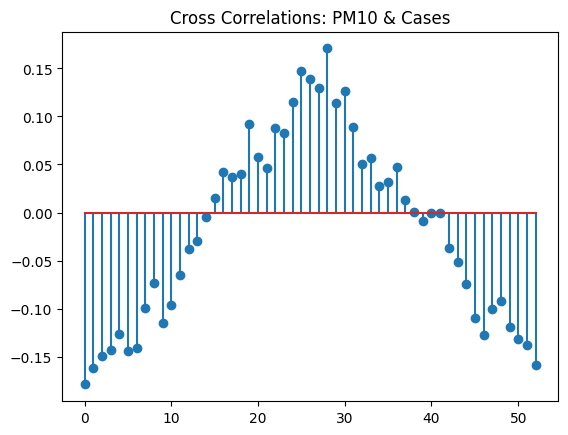

Adjusted for Month


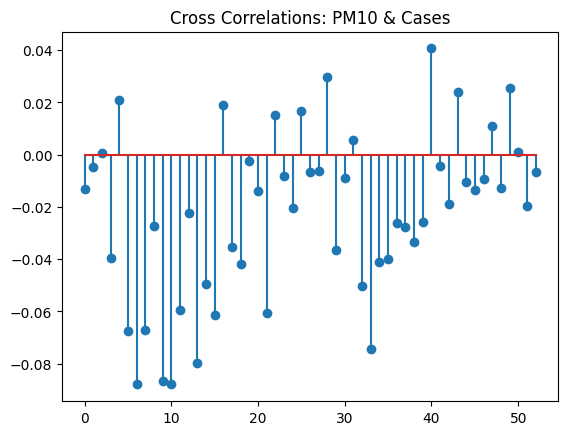

Unadjusted


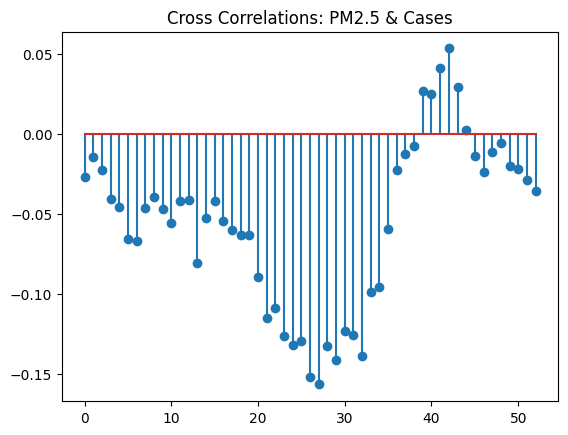

Adjusted for Month


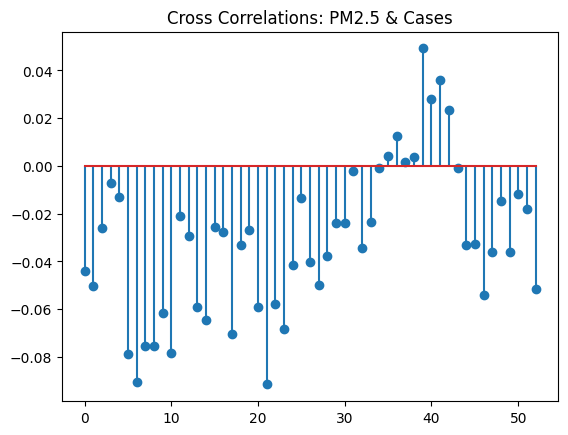

Unadjusted


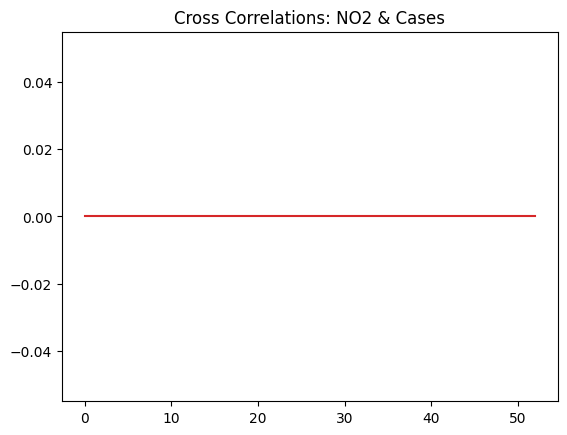

Adjusted for Month


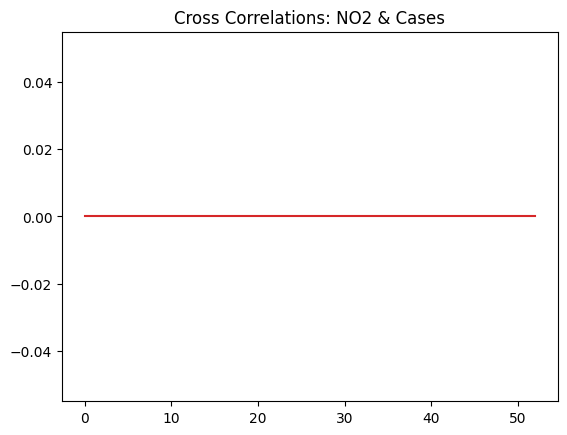

Unadjusted


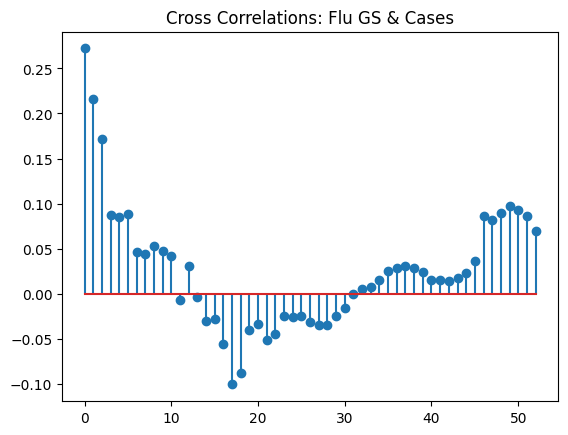

Adjusted for Month


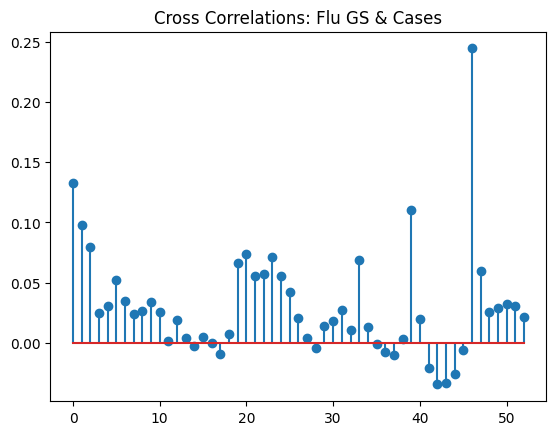

Unadjusted


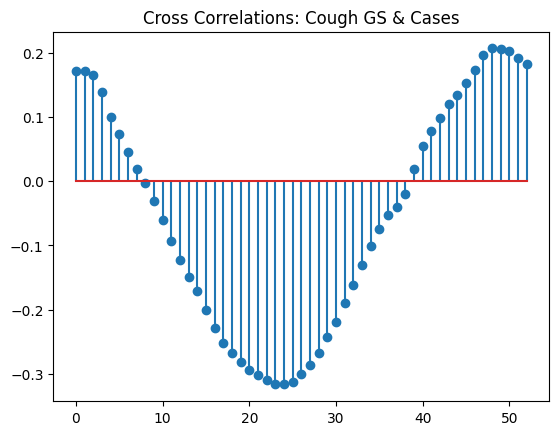

Adjusted for Month


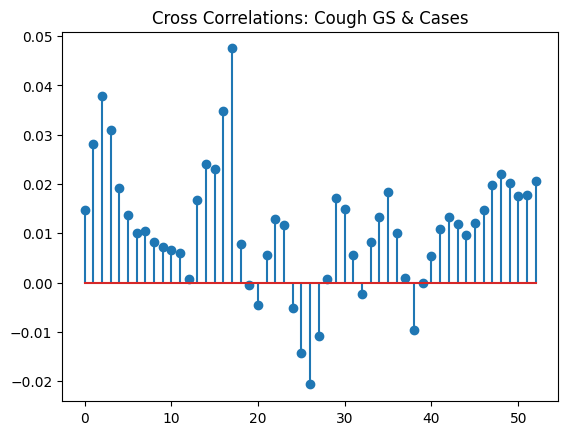

Unadjusted


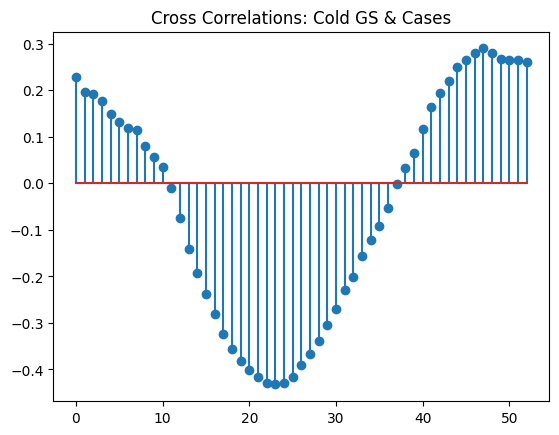

Adjusted for Month


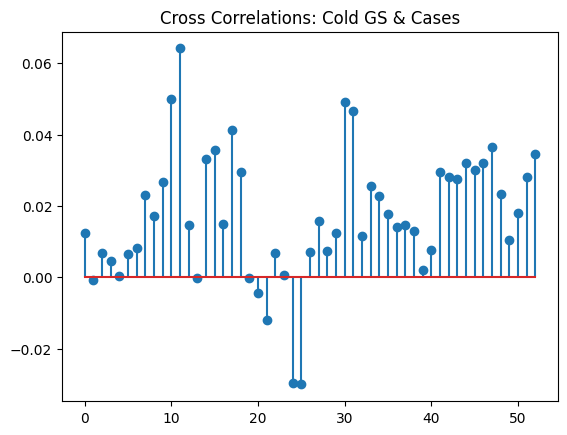

In [392]:
for v in ind_cont_vars:
    print(75*'=')
    print('Unadjusted')
    print(75*'=')
    plot_ccf_sm(df[v], df['Cases'],nlags=52)
    print(75*'=')
    print('Adjusted for Month')
    print(75*'=')
    plot_ccf_sm(weighted_transformed_df[v],weighted_transformed_df['Cases'],52)


---
These lagged terms will be included in a multiple linear regression model, alongside auto-lags, months, and other terms
